<a href="https://colab.research.google.com/github/Boukhlifi/sentiments-analysis/blob/main/Analyse_des_sentiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
pip install nltk

In [3]:
import pandas as pd
import numpy as np
import re
import collections
import matplotlib.pyplot as plt
from pathlib import Path

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

#les packages pour la preparation de data
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import LabelEncoder

#les packages pour la modelisation
from keras import models
from keras import layers
from keras import regularizers#pour la regularisation


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [4]:
#je vais creer une fonction pour entrainer un modéle multiclasse,ou la sortie sera l'historique de l'entrainement du modéle
def deep_model(model, x_train, y_train, x_valid, y_valid):
  model.compile(optimizer = 'rmsprop',
                loss= 'categorical_crossentropy',#car on a trois sentiments de la basse de données twits
                metrics =['accuracy'])
  history = model.fit(x_train,
                      y_train,
                      epochs=20,
                      batch_size=512,
                      validation_data=(x_valid,y_valid),
                      verbose=0)
  return history

In [5]:
#lorsqu'on veut evaluer un modele,c'est apartir de son historique(soit val_acc et train_acc ou val_loss et train_loss)
#donc cette fonction, vas nous afficher l'historique de val ou loss pour train et validation
#pour savoir si mon modele a subit a un surapprentissage ou non,alors c'est pour detecter l'overfitting visuelement
def eval_metric(model, history, metric_name):
  metric = history.history[metric_name] #loss ou acc pour le train
  val_metric = history.history['val_' + metric_name]#val_acc ou val_loss pour les données de validation
  
  e =range(1,21)#epochs+1
  
  plt.plot(e, metric, 'bo', label = 'train '+ metric_name)
  plt.plot(e, val_metric, 'b', label = 'validation '+ metric_name)
  plt.xlabel("nombre d'epochs")
  plt.ylabel(metric_name)
  plt.title('comparing training and validation '+metric_name+' for '+model.name)
  plt.legend()
  plt.show()

In [43]:
#d'apres la fonction deep_model qui nous retoune l'history,donc je vais faire sortir le meilleur epochs,
#c'est celui qui vas me generer une valeur de loss minimale et une valeur de acc maximale
#dans cette fonction on vas reentrainer notre modéle ,en s'arretant dans l'epochs le plus optimal cad qui va me doner le meilleur resultat
#de loss pour val et train
def test_model(model, x_train, y_train, x_test, y_test, epoch_stop):
  model.fit(x_train,
            y_train,
            epochs= epoch_stop,
            batch_size=512,
            verbose=0)
  results = model.evaluate(x_test,y_test)
  print('test accuracy : {0:.2f}%'.format(results[1]*100))

In [7]:
#cette fonction,va nous comprarer le modéle regularisé et non regularisé
#il va nous afficher l'historique de acc ou loss pour le modéle regularisé et non regularisé
def compare_models_by_metrics(model1, model2, model_hist1, model_hist2,metric):
  metric_model_1 = model_hist1.history[metric]
  metric_model_2 = model_hist2.history[metric]

  e =range(1, 21)

  metrics_dict = {
      'acc' : 'Training Accuracy',
      'loss' : 'Training loss',
      'val_acc' : 'Validation Accuracy',
      'val_loss' : 'Validation loss'}

  metric_label = metrics_dict[metric]

  plt.plot(e, metric_model_1, 'ro', label = model1.name)#rouge pointié
  plt.plot(e, metric_model_2, 'r', label = model2.name)
  plt.xlabel("nombre d'epochs")
  plt.ylabel(metric_label)
  plt.title('comparing '+metric_label+' between '+ model1.name +' and ' + model2.name)
  plt.legend()
  plt.show()



In [8]:
#cette fonction ,il vas nous retouner l'epoch le plus optimale,qui a une veleur minimal de loss
def optimal_epochs(model_hist):
  min_epoch = np.argmin(model_hist.history['val_loss']) + 1
  print("l'epochs le plus optimale est : {}".format(min_epoch))
  return min_epoch

In [9]:
#cette fonction c'est pour supprimer les mots les plus fréquents dans une langue,
#je veus supprimer ces mots car je ne veux pas que ves mots prennenet de la place dans mon basse de données 
#ou prennent un temps de traitement précieux,et ils ne vont pas nous donner une information sur le sentiments
def remove_stopwords(input_text):
  stopwords_list = stopwords.words('english')#cette fonction c'est pour nous generer les mots les plus fréquents dans une langue
  whitelist = ["n't", "not", "no"]#je vais laisser ces mots qui seront utuls pour l'analyses des sentiments
  words =input_text.split()
  clean_words = [word for word in words if (word not in stopwords_list or word in whitelist) and len(word) > 1]
  return ' '.join(clean_words)

In [10]:
#les experions regulieres qui sont des shemas utulisés pour effectuer des recherches et des remplacemnts dans des chaines de caractéres
#pourque le modele construite soit réalisé dans notre airline
def remove_mentions(input_text):
  return re.sub(r'@\w+','',input_text)#il va enlever toutes la mention,toutes les chaines liés a @

In [11]:
#La base de données est téléchargé du site Kaggle [Twitter US Airline Sentiment de Kaggle]
#https://www.kaggle.com/crowdflower/twitter-airline-sentiment

In [12]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [13]:
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Tweets.csv')
df

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14635,569587686496825344,positive,0.3487,NaN,0.0000,American,NaN,KristenReenders,NaN,0,@AmericanAir thank you we got on a different f...,NaN,2015-02-22 12:01:01 -0800,NaN,NaN
14636,569587371693355008,negative,1.0000,Customer Service Issue,1.0000,American,NaN,itsropes,NaN,0,@AmericanAir leaving over 20 minutes Late Flig...,NaN,2015-02-22 11:59:46 -0800,Texas,NaN
14637,569587242672398336,neutral,1.0000,NaN,NaN,American,NaN,sanyabun,NaN,0,@AmericanAir Please bring American Airlines to...,NaN,2015-02-22 11:59:15 -0800,"Nigeria,lagos",NaN
14638,569587188687634433,negative,1.0000,Customer Service Issue,0.6659,American,NaN,SraJackson,NaN,0,"@AmericanAir you have my money, you change my ...",NaN,2015-02-22 11:59:02 -0800,New Jersey,Eastern Time (US & Canada)


In [14]:
#pour moi ce qui m'intersse plus c'est le text et le sentiments
#je vais faire une permutation aléatoire selon l'indice pour avoir les trois sentiments dans la separation split
df = df.reindex(np.random.permutation(df.index))
df =df[['text', 'airline_sentiment']]
df.text = df.text.apply(remove_stopwords).apply(remove_mentions)


In [15]:
x_train, x_test, y_train, y_test =train_test_split(df.text,df.airline_sentiment, test_size =0.1, random_state=42)
print('train data : ',x_train.shape[0])
print('test data : ',x_test.shape[0])

train data :  13176
test data :  1464


In [16]:
max_len =20 # le nombre des mots dans une sequence
tk =Tokenizer(num_words= 10000,#un nombre maximum a conservé dans un dictionnaire
              filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',#les caractéres qui seront filtrés du text
              lower = True,
              char_level = False,#si true tous les carateres seront traité comme un tokens
              split = ' '#split pour la devision des mots
              )
tk.fit_on_texts(x_train)

print("appliqueation de tokenize sur {} documents.".format(tk.document_count))#la taille de mon x_train
print("{} words in dictionnary.".format(tk.num_words))
print('les 5 mots les plus repétés sont : {}'.format(collections.Counter(tk.word_counts).most_common(10)))


appliqueation de tokenize sur 13176 documents.
10000 words in dictionnary.
les 5 mots les plus repétés sont : [('flight', 3518), ('not', 1428), ('no', 1369), ('get', 1201), ('t', 1075), ('co', 1069), ('http', 1019), ('thanks', 962), ('cancelled', 949), ('service', 856)]


In [17]:
#l'indice de chaque mot
#print(tk.word_index)

{'flight': 1, 'not': 2, 'no': 3, 'get': 4, 't': 5, 'co': 6, 'http': 7, 'thanks': 8, 'cancelled': 9, 'service': 10, 'you': 11, 'help': 12, 'time': 13, 'customer': 14, 'hours': 15, 'amp': 16, 'us': 17, "i'm": 18, 'flights': 19, 'hold': 20, 'plane': 21, 'thank': 22, 'still': 23, 'please': 24, 'one': 25, 'would': 26, 'need': 27, 'delayed': 28, "can't": 29, 'gate': 30, 'back': 31, 'call': 32, 'bag': 33, 'flightled': 34, 'hour': 35, 'it': 36, 'got': 37, 'like': 38, 'phone': 39, 'late': 40, 'today': 41, 'now': 42, 'airline': 43, 'me': 44, 'guys': 45, 'waiting': 46, 'fly': 47, 'know': 48, 'way': 49, 'trying': 50, 'airport': 51, 'day': 52, 'great': 53, 'this': 54, 'going': 55, 'never': 56, 'flying': 57, 'wait': 58, 'weather': 59, "i've": 60, 'make': 61, 'delay': 62, 'go': 63, 'change': 64, 'really': 65, 'check': 66, 'tomorrow': 67, '2': 68, 'good': 69, 'last': 70, 'home': 71, 'even': 72, 'minutes': 73, 'people': 74, 'the': 75, 'bags': 76, 'another': 77, 'new': 78, 'want': 79, 'take': 80, 'unite

In [18]:
#apres avoir creer le dictionnaire,nous pouvons mnt convertir le text d'un tweets a un vecteur binaire de taille 10000
x_train_oh = tk.texts_to_matrix(x_train,mode='binary')
x_test_oh = tk.texts_to_matrix(x_test,mode='binary')
print(x_train_oh.shape)

(13176, 10000)


In [19]:
#convertir les labels des classes en un vecteur de taille 3
le = LabelEncoder()
y_train_le = le.fit_transform(y_train)#pour le transformer a un chiffre
y_test_le = le.fit_transform(y_test)
y_train_oh = to_categorical(y_train_le)
y_test_oh = to_categorical(y_test_le)

print('"{}" is converted into {}'.format(y_train[0], y_train_le[0]))
print('"{}" is converted into {}'.format(y_train_le[0], y_train_oh[0]))

"neutral" is converted into 1
"1" is converted into [0. 1. 0.]


In [20]:
x_train_rest, x_valid, y_train_rest, y_valid = train_test_split(x_train_oh,y_train_oh, test_size =0.1, random_state=42)
assert x_train_rest.shape[0] == y_train_rest.shape[0]
assert x_test.shape[0] == y_test.shape[0]
print("validation data est : ",x_valid.shape)

validation data est :  (1318, 10000)


In [21]:
NB_WORDS=10000
base_model = models.Sequential()
base_model.add(layers.Dense(64, activation='relu', input_shape=(NB_WORDS,)))
base_model.add(layers.Dense(64, activation='relu'))
base_model.add(layers.Dense(3, activation='softmax'))
base_model._name = "Baseline_model"
base_model.summary()
#(10000+1) * 64= 640064 
#(64 + 1) * 64 = 4160
#(64 + 1) *  3 = 195 

Model: "Baseline_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                640064    
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 195       
Total params: 644,419
Trainable params: 644,419
Non-trainable params: 0
_________________________________________________________________


In [22]:
base_hitory = deep_model(base_model, x_train_rest, y_train_rest, x_valid, y_valid)
base_epoch_min  = optimal_epochs(base_hitory)
#apres le premier epoch ,le modele a subit a une sur apprentissage

l'epochs le plus optimale est : 3


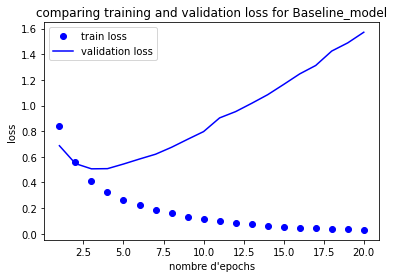

In [23]:
eval_metric(base_model, base_hitory, 'loss')
#d'apres ce plot,on voit bien que le modéle a subit a une sur apprentisage,donc le modele et plus complexe que les données

In [24]:
#1ere option: poreduire la capacité du modéle
reduced_model = models.Sequential()
reduced_model.add(layers.Dense(16, activation='relu', input_shape=(NB_WORDS,)))
reduced_model.add(layers.Dense(3, activation='softmax'))
reduced_model._name = "Reduced_model"
reduced_model.summary()

Model: "Reduced_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 16)                160016    
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 51        
Total params: 160,067
Trainable params: 160,067
Non-trainable params: 0
_________________________________________________________________


In [25]:
reduced_hitory = deep_model(reduced_model, x_train_rest, y_train_rest, x_valid, y_valid)
reduced_epoch_min  = optimal_epochs(reduced_hitory)
#donc il faut plus d'epochs pour avant que le modéle reduit ne commence a sur apprentisage

l'epochs le plus optimale est : 12


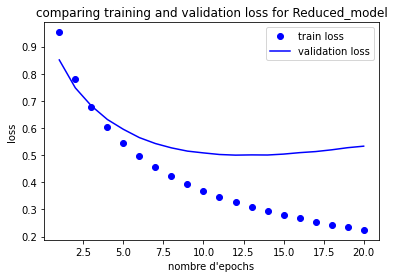

In [26]:
eval_metric(reduced_model, reduced_hitory, 'loss')

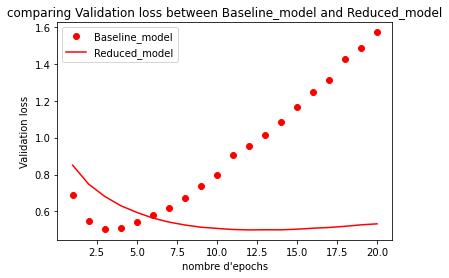

In [27]:
#on veut comparer le loss de validation pour les  deux models
compare_models_by_metrics(base_model, reduced_model, base_hitory, reduced_hitory,'val_loss')
#on remarque que la valeur de loss pour reduced_model et plus petite que base_model
#et pour le reduced_model l'overfittion a éte commencé jusqu'a epoch 12 ,pas comme base modele ,l'epoch 3 

In [28]:
#2eme option: la regularisation l2
regularized_model = models.Sequential()
regularized_model.add(layers.Dense(64,kernel_regularizer=regularizers.l2(0.001) ,activation='relu', input_shape=(NB_WORDS,)))
regularized_model.add(layers.Dense(64,kernel_regularizer=regularizers.l2(0.001) , activation='relu'))
regularized_model.add(layers.Dense(3, activation='softmax'))
regularized_model._name = "l2_regularization_model"
regularized_model.summary()

Model: "l2_regularization_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 64)                640064    
_________________________________________________________________
dense_6 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_7 (Dense)              (None, 3)                 195       
Total params: 644,419
Trainable params: 644,419
Non-trainable params: 0
_________________________________________________________________


In [29]:
regularized_hitory = deep_model(regularized_model, x_train_rest, y_train_rest, x_valid, y_valid)
regularized_epoch_min  = optimal_epochs(regularized_hitory)

l'epochs le plus optimale est : 3


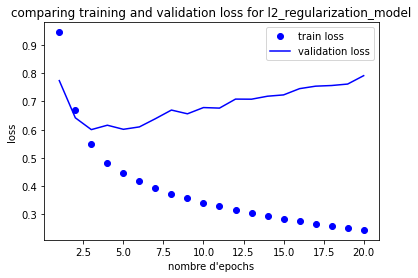

In [30]:
eval_metric(regularized_model, regularized_hitory, 'loss')
#on remarque que la regularisation l2 n'as pas pu bien regularisé notre modéle

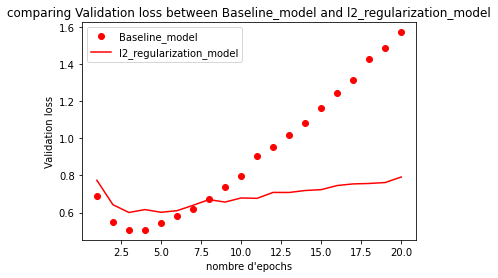

In [31]:
compare_models_by_metrics(base_model, regularized_model, base_hitory, regularized_hitory,'val_loss')

In [37]:
#ajouter des couches dropout
#j'ai ajouté 2 couches dropout apres chaque couche fully_connectd
drop_model = models.Sequential()
drop_model.add(layers.Dense(64,activation='relu', input_shape=(NB_WORDS,)))
drop_model.add(layers.Dropout(0.5))#50% des neuronnes vont fonctionnés, et 50% non
drop_model.add(layers.Dense(64, activation='relu'))
drop_model.add(layers.Dropout(0.5))
drop_model.add(layers.Dense(3, activation='softmax'))
drop_model._name = "Dropout_layers_model"
drop_model.summary()

Model: "Dropout_layers_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 64)                640064    
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 3)                 195       
Total params: 644,419
Trainable params: 644,419
Non-trainable params: 0
_________________________________________________________________


In [38]:
drop_hitory = deep_model(drop_model, x_train_rest, y_train_rest, x_valid, y_valid)
drop_epoch_min  = optimal_epochs(drop_hitory)

l'epochs le plus optimale est : 6


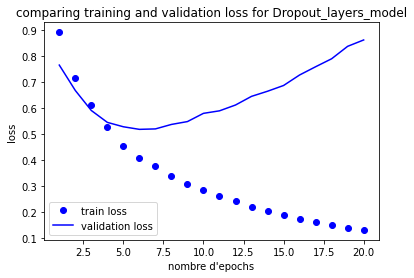

In [39]:
eval_metric(drop_model, drop_hitory, 'loss')
#tjrs le probléme d sur apprentissage

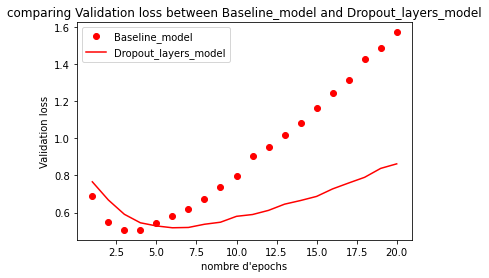

In [40]:
compare_models_by_metrics(base_model, drop_model, base_hitory, drop_hitory,'val_loss')

In [44]:
#entrainement sur les donnés complétes du train et évaluation sur les données de test
test_model(base_model, x_train_oh, y_train_oh, x_test_oh, y_test_oh, base_epoch_min)

46/46 [==============================] - 0s 3ms/step - loss: 1.3044 - accuracy: 0.7589
test accuracy : 75.89%


In [45]:
test_model(reduced_model, x_train_oh, y_train_oh, x_test_oh, y_test_oh, reduced_epoch_min)

46/46 [==============================] - 0s 3ms/step - loss: 0.6007 - accuracy: 0.7937
test accuracy : 79.37%


In [46]:
test_model(regularized_model, x_train_oh, y_train_oh, x_test_oh, y_test_oh, regularized_epoch_min)

46/46 [==============================] - 0s 3ms/step - loss: 0.7085 - accuracy: 0.8005
test accuracy : 80.05%


In [47]:
test_model(drop_model, x_train_oh, y_train_oh, x_test_oh, y_test_oh, drop_epoch_min)


46/46 [==============================] - 0s 3ms/step - loss: 0.8334 - accuracy: 0.7951
test accuracy : 79.51%
